# Experiments on the small business administration dataset

temporal shift


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from utilexp import *
from expnns.preprocessor import min_max_scale

In [2]:

df = pd.read_csv("../datasets/sba/SBAcase.11.13.17.csv", delimiter=',')
df = df.dropna(axis=1)
df = df.drop(columns=['ApprovalDate', "LoanNr_ChkDgt", "Name", "Zip", "City", "State", "NAICS", "FranchiseCode", 'BalanceGross', "MIS_Status", "Selected", "UrbanRural", 'Recession', 'New', 'RealEstate', 'Portion'])
continuous_features = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',
       'DisbursementGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'daysterm']

df1 = df[df['ApprovalFY'] < 2006].drop(columns="ApprovalFY")
df2 = df[df['ApprovalFY'] >= 2006].drop(columns="ApprovalFY")
df = df.drop(columns=["ApprovalFY"])
# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df1_mm = min_max_scale(df1, continuous_features, min_vals, max_vals)
df2_mm = min_max_scale(df2, continuous_features, min_vals, max_vals)

# get X, y
X1, y1 = df1_mm.drop(columns=['Default']), pd.DataFrame(1 - df1_mm['Default'])
X2, y2 = df2_mm.drop(columns=['Default']), pd.DataFrame(1 - df2_mm['Default'])
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                    random_state=5)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2, test_size=SPLIT, shuffle=True,
                                                    random_state=2)

ordinal_features = {}
discrete_features = {}
columns = list(df1_mm.columns)
feat_var_map = {}
for i in range(len(X1.columns)):
    feat_var_map[i] = [i]


In [3]:
display(df1_mm)

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,daysterm,Default
0,0.117647,0.001538,0.0,0.0,0.012110,0.0,0.010872,0.006035,0.117647,0
1,0.183007,0.001538,0.0,0.0,0.010893,0.0,0.010872,0.006035,0.183007,0
2,0.117647,0.015385,0.0,0.0,0.010893,0.0,0.010872,0.006035,0.117647,0
3,0.117647,0.009231,0.0,0.0,0.019551,0.0,0.019399,0.010768,0.117647,0
5,0.274510,0.001538,0.0,0.0,0.022072,0.0,0.019399,0.010768,0.274510,0
...,...,...,...,...,...,...,...,...,...,...
2089,0.980392,0.001538,0.0,0.0,0.084481,0.0,0.083351,0.069933,0.980392,0
2098,0.980392,0.006154,0.0,0.0,0.040761,0.0,0.040290,0.036422,0.980392,0
2099,0.274510,0.003077,0.0,0.0,0.019551,0.0,0.019399,0.017868,0.274510,0
2100,0.392157,0.004615,0.0,0.0,0.106622,0.0,0.211256,0.176429,0.392157,0


In [4]:
display(df2_mm)

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,daysterm,Default
4,0.784314,0.100000,0.023077,0.121495,0.146381,0.000000,0.144319,0.161283,0.784314,0
6,0.879085,0.003077,0.000000,0.003738,0.126686,0.163674,0.124920,0.104544,0.879085,1
7,0.274510,0.001538,0.015385,0.001869,0.026930,0.000000,0.010872,0.006035,0.274510,0
13,0.248366,0.003077,0.000000,0.003738,0.010893,0.019675,0.010872,0.006035,0.248366,1
15,0.196078,0.020000,0.053846,0.037383,0.008729,0.000000,0.008740,0.004851,0.196078,0
...,...,...,...,...,...,...,...,...,...,...
2093,0.274510,0.004615,0.000000,0.005607,0.043690,0.000000,0.040716,0.022601,0.274510,0
2094,0.274510,0.004615,0.000000,0.005607,0.037948,0.000000,0.010872,0.006035,0.274510,0
2095,0.784314,0.009231,0.030769,0.011215,0.310006,0.000000,0.305479,0.340196,0.784314,0
2096,0.784314,0.043077,0.061538,0.052336,0.443330,0.000000,0.436794,0.485978,0.784314,0


# Train and observe model changes

In [4]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [2, 3, 4, 5]
hidden_layer_sizes_vals = [(i) for i in range(3, 20)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals)

nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
search = nns.fit(X1, y1)
print(search.best_params_)


{'max_iter': 5, 'learning_rate_init': 0.05, 'hidden_layer_sizes': 6, 'batch_size': 8}


In [5]:
from sklearn.neural_network import MLPClassifier

#clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=18, learning_rate_init=0.005, batch_size=8,
#                    max_iter=9000, random_state=0)
clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=6, learning_rate_init=0.05, batch_size=8,
                    max_iter=5, random_state=0)
# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X1, y1, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

#clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=18, learning_rate_init=0.005, batch_size=8,
#                    max_iter=9000, random_state=0)
clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=18, learning_rate_init=0.005, batch_size=8,
                    max_iter=9000, random_state=0)
clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X1_train.values)
print('\n', classification_report(y1_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.94 test_accuracy with a std of 0.01
0.92 test_precision_macro with a std of 0.04
0.87 test_recall_macro with a std of 0.03
0.89 test_f1_macro with a std of 0.02

                  precision    recall  f1-score   support

 bad credit (0)      1.000     0.946     0.972        37
good credit (1)      0.990     1.000     0.995       195

       accuracy                          0.991       232
      macro avg      0.995     0.973     0.984       232
   weighted avg      0.991     0.991     0.991       232


                  precision    recall  f1-score   support

 bad credit (0)      0.965     0.926     0.945       149
good credit (1)      0.986     0.994     0.990       778

       accuracy                          0.983       927
      macro avg      0.976     0.960     0.967       927
   weighted avg      0.983     0.983     0.983       927



In [24]:
# save the trained classifier
from joblib import dump, load

#dump(clf, 'sba.joblib')


['sba.joblib']

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [3]:
from joblib import dump, load
import gurobipy
clf = load("sba.joblib")
gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


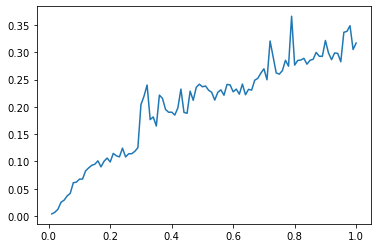

In [9]:
gaps = np.arange(0.01, 1.001, 0.01)
deltas = []
clfs = []
for a, i in enumerate(gaps):
    clfs.append(copy.deepcopy(clf))
    util_exp = UtilExp(clfs[a], X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map,
                   num_test_instances=1000, gap=i)
    deltas.append(util_exp.delta_min)

plt.plot(gaps, deltas)

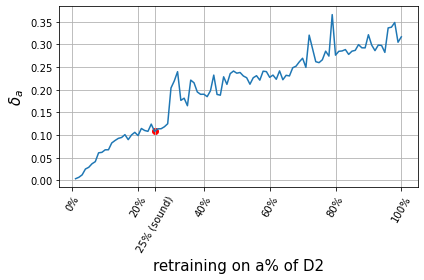

In [79]:
plot_x = np.round(np.concatenate((np.arange(0, 1.01, 0.2), np.array([0.25])))*100).astype(int)
plot_x.sort()
plot_x = list(plot_x)
plot_x = [str(i) + "%" for i in plot_x]
plot_x[2] += " (sound)"
fig, ax = plt.subplots()
ax.plot(gaps, deltas)
ax.grid()
xticks = np.concatenate((np.arange(0, 1.01, 0.2), np.array([0.25])))
xticks.sort()
ax.set_xticks(xticks)
ax.set_xticklabels(plot_x)
ax.set_xlabel("retraining on a% of D2", fontsize=15)
plt.xticks(rotation=60)
ax.set_ylabel("$\delta_a$", fontsize=15)
ax.scatter(0.25, 0.1082, marker='o', color='red')
fig.tight_layout()
fig.savefig("./plots/appendix-delta-sba.png", dpi=300)

In [14]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map, gap=0.25, num_test_instances=200)
print(util_exp.delta_max)
print(util_exp.delta_min)

0.30498064647513345
0.10821238236127151


In [15]:
print(len(X1.values) - np.sum(clf.predict(X1)))

178


In [16]:
valids = util_exp.verify_soundness()
print(len(valids))

percentage of sound model changes: 0.6348314606741573
113


In [30]:
valids = util_exp.verify_soundness(update_test_instances=True)
valids2 = util_exp.verify_soundness()   # percentage should be 1
print(len(valids))

percentage of sound model changes: 0.6348314606741573
test instances updated to sound (x, Delta) pairs, length: 50
percentage of sound model changes: 1.0
50


In [20]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [00:48,  1.04it/s]


total computation time in s: 48.05300450325012
found: 1.0
average normalised L1: 0.018397036223618234
average normalised L0: 0.27084
average lof score: -0.88
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [49]:
#np.save("./results/sba-milp-r.npy", ours_robust_ces)
#ours_robust_ces = list(np.load("./results/sba-milp-r.npy"))

In [31]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:00, 62.03it/s]


total computation time in s: 0.8080010414123535
found: 1.0
average normalised L1: 0.007121704986669339
average normalised L0: 0.11322000000000002
average lof score: 0.56
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.04


In [50]:
#np.save("./results/sba-milp.npy", ours_non_robust_ces)
#ours_non_robust_ces = list(np.load("./results/sba-milp.npy"))

In [22]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  9.17it/s]

1it [00:00, 11.90it/s]

1it [00:00, 12.35it/s]

1it [00:00, 12.50it/s]

1it [00:00, 29.41it/s]
1it [00:00,  2.11it/s]
1it [00:00, 10.75it/s]

1it [00:00, 11.76it/s]

1it [00:00, 12.82it/s]

1it [00:00, 12.66it/s]

1it [00:00, 30.30it/s]
2it [00:00,  2.16it/s]
1it [00:00, 12.82it/s]

1it [00:00, 12.99it/s]

1it [00:00, 13.89it/s]

1it [00:00, 14.71it/s]

1it [00:00, 32.26it/s]
3it [00:01,  2.29it/s]
1it [00:00, 12.05it/s]

1it [00:00, 12.35it/s]

1it [00:00, 11.76it/s]

1it [00:00, 13.16it/s]

1it [00:00, 28.57it/s]
4it [00:01,  2.28it/s]
1it [00:00, 12.19it/s]

1it [00:00, 12.50it/s]

1it [00:00, 13.51it/s]

1it [00:00, 13.70it/s]

1it [00:00, 31.23it/s]
5it [00:02,  2.31it/s]
1it [00:00, 12.50it/s]

1it [00:00, 12.35it/s]

1it [00:00, 12.99it/s]

1it [00:00, 12.82it/s]

1it [00:00, 31.25it/s]
6it [00:02,  2.31it/s]
1it [00:00, 10.31it/s]

1it [00:00, 10.20it/s]

1it [00:00, 11.11it/s]

1it [00:00, 10.99it/s]

1it [00:00, 13

total computation time in s: 40.779000997543335
found: 1.0
average normalised L1: 0.030969949216603582
average normalised L0: 0.870048780487805
average lof score: -0.8048780487804879
counterfactual validity: 0.82
delta validity: 0.68
m2 validity: 0.78


In [51]:
#np.save("./results/sba-roar.npy", roar_ces)
#roar_ces = list(np.load("./results/sba-roar.npy"))

In [41]:
# PROTOTYPES
proto_ces = util_exp.run_proto()
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
11it [03:04, 16.71s/it]No counterfactual found!
12it [03:21, 16.78s/it]No counterfactual found!
29it [08:05, 16.77s/it]No counterfactual found!
35it [09:45, 16.50s/it]No counterfactual found!
49it [13:32, 15.84s/it]No counterfactual found!
50it [13:49, 16.59s/it]


total computation time in s: 829.6176807880402
found: 0.9
average normalised L1: 0.00812217167979019
average normalised L0: 0.1233555555555556
average lof score: 0.6
counterfactual validity: 0.9
delta validity: 0.0
m2 validity: 0.06


In [52]:
#np.save("./results/sba-proto.npy", proto_ces)
#proto_ces = list(np.load("./results/sba-proto.npy"))

In [57]:
# PROTOTYPES-robustness-boosted
proto_ces_robust= util_exp.run_proto_robust(kap=0.1)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
1it [02:04, 124.28s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees

total computation time in s: 6437.946154356003
found: 0.9
average normalised L1: 0.010960993743542645
average normalised L0: 0.19242222222222236
average lof score: -0.022222222222222223
counterfactual validity: 0.9
delta validity: 0.06
m2 validity: 0.88


In [58]:
np.save("./results/sba-proto-r.npy", proto_ces_robust)
#proto_ces_robust = list(np.load("./results/sba-proto-r.npy"))

In [34]:
# WACHTER CF
wachter_ces = util_exp.run_wachter(target_proba=0.95, max_lam_steps=10, lam_init=0.01)
util_exp.evaluate_ces(wachter_ces)


11it [00:19,  1.86s/it]No appropriate lambda range found, try decreasing lam_init
12it [00:21,  1.62s/it]No appropriate lambda range found, try decreasing lam_init
29it [00:51,  1.82s/it]No appropriate lambda range found, try decreasing lam_init
35it [01:00,  1.73s/it]No appropriate lambda range found, try decreasing lam_init
50it [01:27,  1.75s/it]


total computation time in s: 87.34499549865723
found: 0.92
average normalised L1: 0.01818409552615589
average normalised L0: 0.9034782608695651
average lof score: -0.5652173913043478
counterfactual validity: 0.92
delta validity: 0.06
m2 validity: 0.92


In [54]:
#np.save("./results/sba-wachter.npy", wachter_ces)
#wachter_ces = list(np.load("./results/sba-wachter.npy"))

In [56]:
# WACHTER CF - robustness-boosted
wachter_ces_rob = util_exp.run_wachter_robust(target_proba=0.95, lam_init=0.01)
util_exp.evaluate_ces(wachter_ces_rob)


11it [04:11, 27.93s/it]No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
12it [04:25, 23.75s/it]No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropr

total computation time in s: 1196.9375748634338
found: 0.92
average normalised L1: 0.022542965482078025
average normalised L0: 0.908304347826087
average lof score: -0.782608695652174
counterfactual validity: 0.92
delta validity: 0.34
m2 validity: 0.92


In [59]:
np.save("./results/sba-wachter-r.npy", wachter_ces_rob)
#wachter_ces_rob = list(np.load("./results/sba-wachter-r.npy"))

In [36]:
delta = util_exp.delta_min
print(np.arange(delta / 10, delta * 1.01, delta / 10))
plot_x = np.arange(0.1, 1.01, 0.1)
print(delta)
print(plot_x)


[0.01082124 0.02164248 0.03246371 0.04328495 0.05410619 0.06492743
 0.07574867 0.08656991 0.09739114 0.10821238]
0.10821238236127151
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [37]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0., 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


In [38]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [60]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_wachter = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces, target_delta=util_exp.delta_min)
delta_vals_wachter_rob = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces_rob, target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)
delta_vals_proto_rob = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces_robust, target_delta=util_exp.delta_min)

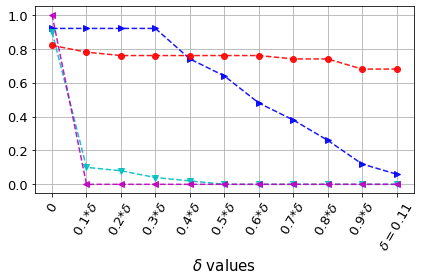

In [63]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/delta-val-sba.png", dpi=300)

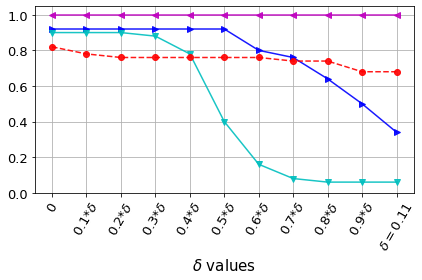

In [64]:
fig, ax = plt.subplots()
#ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/robust-delta-val-sba.png", dpi=300)